<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/25_rag_pytorch/25_rag_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG with PyTorch

## Defining helper functions

In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def tsne_plot(data, plot):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(50, data.shape[0] - 1))  # Using 50 or less based on data size
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    colors = plt.cm.rainbow(np.linspace(0, 1, len(data_3d)))
    for idx, point in zip(range(len(data_3d)), data_3d):
        ax.scatter(point[0], point[1], point[2], color=colors[idx], label=f'{plot} {idx+1}')

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization of '+ plot +' Embeddings')
    plt.legend(title=plot +' Index', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Embeddings using BERT and PyTorch Hub

In [2]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
# Input text to get embeddings for
input_text = [("This is an example sentence for BERT embeddings.", "How do you like it "),("There are other models")]

### Tokenization

In [4]:
input_ids = tokenizer.batch_encode_plus(input_text,add_special_tokens=True,padding=True,truncation=True)
input_ids

{'input_ids': [[101, 2023, 2003, 2019, 2742, 6251, 2005, 14324, 7861, 8270, 4667, 2015, 1012, 102, 2129, 2079, 2017, 2066, 2009, 102], [101, 2045, 2024, 2060, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

### Text decoding and verification

In [5]:
text=tokenizer.decode(input_ids['input_ids'][0])
print(text)
print(f"length {len(text.split())}")

[CLS] this is an example sentence for bert embeddings. [SEP] how do you like it [SEP]
length 16


In [6]:
input_ids['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

### Device and Convert Tensor

In [7]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [8]:
input_ids_tensors = torch.tensor(input_ids['input_ids']).to(DEVICE)
mask_tensors = torch.tensor(input_ids['attention_mask']).to(DEVICE)

### Loading the BERT model

In [9]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
bert_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [11]:
word_embding=bert_model(input_ids_tensors,mask_tensors)

### Generating aggregated mean embeddings using BERT for RAG

In [12]:
from tqdm import tqdm

# Initialize a list to store the mean embeddings for each input sequence
aggregated_mean_embeddings = []

# Loop over each pair of input_ids and attention_masks
for token_ids, attention_mask in tqdm(zip(input_ids['input_ids'], input_ids['attention_mask'])):
    # Convert list of token ids and attention mask to tensors
    token_ids_tensor = torch.tensor([token_ids]).to(DEVICE)
    attention_mask_tensor = torch.tensor([attention_mask]).to(DEVICE)
    print("token_ids_tensor shape:",token_ids_tensor.shape, attention_mask_tensor.shape)  # Print the shapes of the input tensors
    with torch.no_grad():  # Disable gradient calculations for faster execution
        # Retrieve the batch of word embeddings from the BERT model
        embeddings = bert_model(token_ids_tensor, attention_mask=attention_mask_tensor)[0].squeeze(0)
        print("Word embeddings shape:", embeddings.shape)

        # Count and print the number of zero-padding embeddings
        num_zero_paddings = (attention_mask_tensor == 0).sum().item()
        print("Number of zero padding embeddings:", num_zero_paddings)

        # Create a mask for positions that are not zero-padded
        valid_embeddings_mask = attention_mask_tensor[0] != 0
        print("valid_embeddings_mask:",valid_embeddings_mask)

        # Filter out the embeddings corresponding to zero-padded positions
        filtered_embeddings = embeddings[valid_embeddings_mask, :]
        print("Word embeddings after zero padding embeddings removed:", filtered_embeddings.shape)

        # Compute the mean of the filtered embeddings
        mean_embedding = filtered_embeddings.mean(axis=0)
        print("Mean embedding shape:", mean_embedding.shape)

        # Append the mean embedding to the list, adding a batch dimension
        aggregated_mean_embeddings.append(mean_embedding.unsqueeze(0))

# Concatenate all mean embeddings to form a single tensor
aggregated_mean_embeddings = torch.cat(aggregated_mean_embeddings)
print('All mean embeddings shape:', aggregated_mean_embeddings.shape)

1it [00:00,  5.74it/s]

token_ids_tensor shape: torch.Size([1, 20]) torch.Size([1, 20])
Word embeddings shape: torch.Size([20, 768])
Number of zero padding embeddings: 0
valid_embeddings_mask: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])
Word embeddings after zero padding embeddings removed: torch.Size([20, 768])
Mean embedding shape: torch.Size([768])
token_ids_tensor shape: torch.Size([1, 20]) torch.Size([1, 20])


2it [00:00,  5.63it/s]

Word embeddings shape: torch.Size([20, 768])
Number of zero padding embeddings: 14
valid_embeddings_mask: tensor([ True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
Word embeddings after zero padding embeddings removed: torch.Size([6, 768])
Mean embedding shape: torch.Size([768])
All mean embeddings shape: torch.Size([2, 768])


In [13]:
def aggregate_embeddings(input_ids, attention_masks, bert_model=bert_model):
    """
    Converts token indices and masks to word embeddings, filters out zero-padded embeddings,
    and aggregates them by computing the mean embedding for each input sequence.

    """
    mean_embeddings = []
    # Process each sequence in the batch
    print('number of inputs',len(input_ids))
    for input_id, mask in tqdm(zip(input_ids, attention_masks)):
        input_ids_tensor = torch.tensor([input_id]).to(DEVICE)
        mask_tensor = torch.tensor([mask]).to(DEVICE)

        with torch.no_grad():
            # Obtain the word embeddings from the BERT model
            word_embeddings = bert_model(input_ids_tensor, attention_mask=mask_tensor)[0].squeeze(0)

            # Filter out the embeddings at positions where the mask is zero
            valid_embeddings_mask=mask_tensor[0] != 0
            valid_embeddings = word_embeddings[valid_embeddings_mask,:]
            # Compute the mean of the filtered embeddings
            mean_embedding = valid_embeddings.mean(dim=0)
            mean_embeddings.append(mean_embedding.unsqueeze(0))

    # Concatenate the mean embeddings from all sequences in the batch
    aggregated_mean_embeddings = torch.cat(mean_embeddings)
    return aggregated_mean_embeddings

In [14]:
def text_to_emb(list_of_text,max_input=512):
    data_token_index  = tokenizer.batch_encode_plus(list_of_text, add_special_tokens=True,padding=True,truncation=True,max_length=max_input)
    question_embeddings=aggregate_embeddings(data_token_index['input_ids'], data_token_index['attention_mask'])
    return question_embeddings

## Convert questions and the song lyrics into embeddings


In [15]:
import re
def process_song(song):
    # Remove line breaks from the song
    song_new = re.sub(r'[\n]', ' ', song)

    # Remove single quotes from the song
    song_new = [song_new.replace("\'", "")]

    return song_new

In [16]:
song_questions = [
    "Does this song contain any violent themes, such as references to guns, killing, or physical aggression? Example: Does the song describe or promote physical violence, like fighting or shootings?",
    "Are there any explicit lyrics or bad words used in this song that might be considered offensive or inappropriate? Example: Does the song use language commonly recognized as profanity or derogatory terms?",
    "Is the overall content of this song suitable for children, considering its themes, language, and messages? Example: Are there elements in the song that could be deemed too mature or unsuitable for young listeners?",
    "Does this song explicitly mention weapons, such as guns, knives, or other similar items? Example: Are specific types of weapons described or glorified in the lyrics?",
    "Are the messages conveyed in this song positive and uplifting for children? Example: Does the song promote values like kindness, friendship, and positivity?",
    "Does this song include any sexual content, references to sexual behavior, or suggestive language? Example: Are there lyrics that explicitly or implicitly discuss sexual themes or experiences?",
    "Does this song offer any educational value, such as teaching the alphabet, basic math, or other learning content? Example: Are there educational segments in the song that could help children learn fundamental skills like the ABCs or counting?",
    "Does this song promote emotional resilience and social skills among children? Example: Does the song include themes of overcoming challenges or building friendships?"
]

In [17]:
embeddings_questions=street=text_to_emb(song_questions)

number of inputs 8


8it [00:01,  4.34it/s]


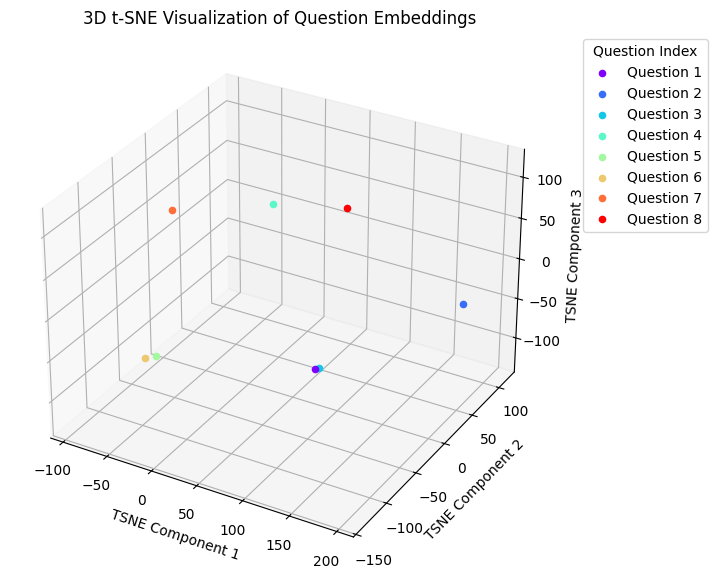

In [18]:
tsne_plot(embeddings_questions, "Question")

In [19]:
yes_responses = [
    "Yes, this song contains violent themes, including references to guns, killing, or physical aggression, and is not suitable for children.",
    "Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.",
    "No, the overall content of this song is not suitable for children as it includes themes, language, and messages that are too mature or unsuitable for young listeners.",
    "Yes, this song explicitly mentions weapons, such as guns and knives, which could be disturbing or inappropriate for children’s entertainment.",
    "Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.",
    "Yes, this song includes sexual content and references to sexual behavior or suggestive language, which are inappropriate for a child-friendly environment.",
    "Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.",
    "Yes, this song promotes emotional resilience and social skills, incorporating themes about overcoming challenges and building friendships, which are essential for children's development."
]

In [20]:
embeddings_responses = text_to_emb(yes_responses)

number of inputs 8


8it [00:01,  6.86it/s]


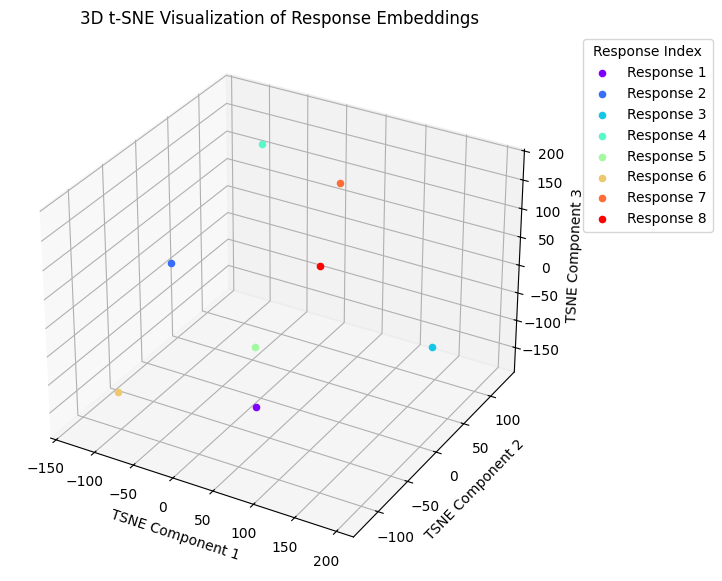

In [21]:
tsne_plot(embeddings_responses, "Response")

In [22]:
song_rage = """
This time the bullet cold rocked ya yeah
A yellow ribbon instead of a swastika
Nothing proper about ya propaganda
Fools follow rules when the set command ya
Said it was blue when ya blood was read yeah
That's how you got a bullet blasted through ya head
Blasted through ya head blasted through ya head
I give a shout out to the living dead
Who stood and watched as the feds cold centralized
So serene on the screen he was mesmerized
Cellular the phones sounding a death tone
Corporations cold turn ya to stone before ya realize
They load the clip in omnicolour
Said they pack the 9 they fire it at prime time
The sleeping gas every home was like alcatraz
And mutha f**kas lost their minds
Just victims of the in house drive by
They say jump you say how high yeah
Just victims of the in house drive by
They say jump you say how high
Jumping sheld off
Yeh just cream for

Just victims of the in house drive by
They say jump you say how high yeah
Just victims of the in house drive by
They say jump you say how high
Checka checka check it out
Load load the clip wow each other
Said they pack the 9 they fire it at prime time
The sleeping gas every home was like alcatraz
And mutha f**kas lost their minds
No escape from the mass mind rape
Play it again jack and then rewind the tape
And then play it again and again and again
Until ya mind is locked in
Believing all the lies that they're telling ya
Buying all the products that they're selling ya
They say jump and ya say how high
Ya brain dead you got a f**king bullet in ya head
Just victims of the in house drive by
They say jump you say how high yeah
Just victims of the in house drive by
They say jump you say how high
Ya standing in line believing the lies
Ya bowing down to the flag ya got a bullet in ya head
Am i standing in line am i believing the lies
I'm bowing down to the flag i got a bullet in my head
Bullet in ya head bullet in ya head
Bullet in ya head bullet in ya head
A bullet in ya head a bullet in ya head
A bullet in ya head a bullet in ya head
A bullet in ya head a bullet in ya head
A bullet in ya head a bullet in ya head
A bullet in ya head a bullet in ya head
A bullet in ya head you gotta bullet in your f**king head
Yeah yeah
"""

In [23]:
song_rage=process_song(song_rage)
embeddings_rage=text_to_emb(song_rage)
embeddings_rage.shape

number of inputs 1


1it [00:01,  1.47s/it]


torch.Size([1, 768])

In [24]:
sesame_street = """
Sunny day
Sweepin' the clouds away
On my way to where the air is sweet
Can you tell me how to get
How to get to Sesame Street?

Come and play
Everything's A-okay
Friendly neighbors there
That's where we meet
Can you tell me how to get
How to get to Sesame Street?

It's a magic carpet ride
Every door will open wide
To happy people like you
Happy people like
What a beautiful

Sunny day
Sweepin' the clouds away
On my way to where the air is sweet
Can you tell me how to get
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
"""

In [25]:
song_sesame_street= process_song(sesame_street)
embeddings_sesame_street=text_to_emb(song_sesame_street)

number of inputs 1


1it [00:00,  2.19it/s]


In [26]:
straight_outta_compton_lyrics = """
You are now about to witness the strength of street knowledge
Straight outta Compton, crazy motherfucker named Ice Cube
From the gang called Niggaz With Attitudes
When I'm called off, I got a sawed off
Squeeze the trigger, and bodies are hauled off
You too, boy, if ya fuck with me
The police are gonna have to come and get me
Off yo' ass, that's how I'm goin' out
For the punk motherfuckers, that's showin' out
Niggas start to mumble, they wanna rumble
Mix 'em and cook 'em in a pot like gumbo
Goin' off on a motherfucker like that
With a gat that's pointed at yo' ass
So give it up smooth
Ain't no tellin' when I'm down for a jack move
Here's a murder rap to keep yo' dancin'
With a crime record like Charles Manson
AK-47 is the tool
Don't make me act the motherfuckin' fool
Me you can go toe to toe, no maybe
I'm knockin' niggas out tha box daily
Yo, weekly, monthly and yearly
Until them dumb motherfuckers see clearly
That I'm down with the capital C-P-T
Boy, you can't fuck with me
So when I'm in your neighborhood, you better duck
'Cause Ice Cube is crazy as fuck
As I leave, believe I'm stompin'
But when I come back, boy, I'm comin' straight outta Compton
Yo, Ren
Whassup?
Tell 'em where you from!
Straight outta Compton, another crazy ass nigga
More punks I smoke, yo, my rep gets bigger
I'm a bad motherfucker and you know this
But the pussy ass niggas don't show this
But I don't give a fuck, I'ma make my snaps
If not from the records, from jackin' the crops
Just like burglary, the definition is jackin'
And when illegally armed, it's called 'packin'
Shoot a motherfucker in a minute
I find a good piece o' pussy, I go up in it
So if you're at a show in the front row
I'ma call you a bitch or dirty-ass ho
You'll probably get mad like a bitch is supposed to
But that shows me, slut, you're composed to
A crazy motherfucker from the street
Attitude legit 'cause I'm tearin' up shit
MC Ren controls the automatic
For any dumb motherfucker that starts static
Not the right-hand 'cause I'm the hand itself
Every time I pull a AK off the shelf
The security is maximum and that's a law
R-E-N spells Ren but I'm raw
See, 'cause I'm the motherfuckin' villain
The definition is clear, you're the witness of a killin'
That's takin' place without a clue
And once you're on the scope, your ass is through
Look, you might take it as a trip
But a nigga like Ren is on a gangsta tip
Straight outta Compton
Eazy is his name, and the boy is comin'
Straight outta Compton
Is a brother that'll smother yo' mother
And make ya sister think I love her
Dangerous motherfucker raises hell
And if I ever get caught, I make bail
See, I don't give a fuck, that's the problem
I see a motherfuckin' cop, I don't dodge him
But I'm smart, lay low, creep a while
And when I see a punk pass, I smile
To me, it's kinda funny, the attitude showin' a nigga drivin'
But don't know where the fuck he's going, just rollin'
Lookin' for the one they call Eazy
But here's a flash, they never seize me
Ruthless! Never seen like a shadow in the dark
Except when I unload, see I'll get over the hesitation
And hear the scream of the one who got the last penetration
Give a little gust of wind and I'm jettin'
But leave a memory no one'll be forgettin'
So what about the bitch who got shot? Fuck her!
You think I give a damn about a bitch? I ain't a sucker!
This is the autobiography of the E, and if you ever fuck with me
You'll get taken by a stupid dope brother who will smother
Word to the motherfucker, straight outta Compton
Damn, that shit was dope!
"""

In [27]:
straight_outta_compton_lyrics= process_song(straight_outta_compton_lyrics)
embeddings_compton=text_to_emb(straight_outta_compton_lyrics)

number of inputs 1


1it [00:02,  2.18s/it]


In [28]:
my_shoe_lyrics="""Barney is a dinosaur from our imagination
And when he's tall
He's what we call a dinosaur sensation
Barney's friends are big and small
They come from lots of places
After school they meet to play
And sing with happy faces
Barney shows us lots of things
Like how to play pretend
ABC's, and 123's
And how to be a friend
Barney comes to play with us
Whenever we may need him
Barney can be your friend too
If you just make-believe him!"""

In [29]:
my_shoe_lyrics= process_song(my_shoe_lyrics)
embeddings_my_shoe=text_to_emb(my_shoe_lyrics)

number of inputs 1


1it [00:00,  3.20it/s]


In [30]:
songs = [song_rage, song_sesame_street, straight_outta_compton_lyrics, my_shoe_lyrics]
embeddings = [text_to_emb(song) for song in songs]
all_embeddings = np.vstack(embeddings)

number of inputs 1


1it [00:01,  1.42s/it]


number of inputs 1


1it [00:00,  2.35it/s]


number of inputs 1


1it [00:02,  2.10s/it]


number of inputs 1


1it [00:00,  2.07it/s]


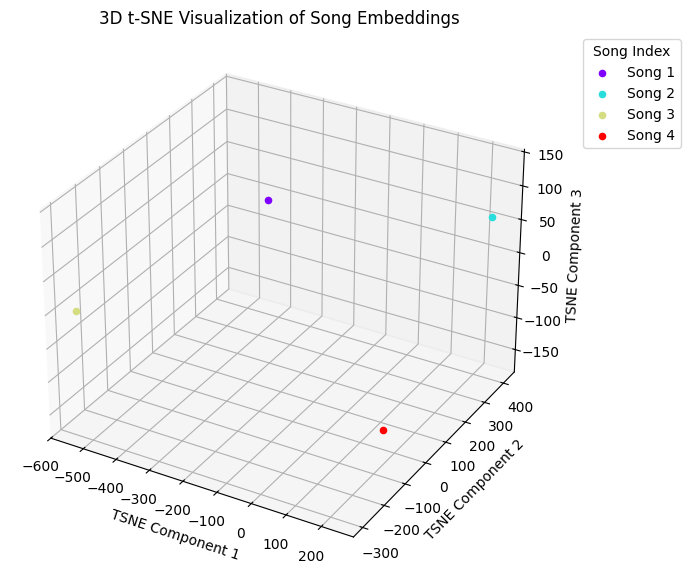

In [31]:
tsne_plot(all_embeddings, "Song")

# Understanding the dot product

In [32]:
dot_product = embeddings_questions@embeddings_rage.T
dot_product = dot_product.reshape(-1)
sorted_indices = torch.argsort(dot_product,descending=True)
sorted_indices=sorted_indices.tolist()

In [33]:
for indices in  sorted_indices[0:3]:
    print(yes_responses[indices])

Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.
Yes, this song explicitly mentions weapons, such as guns and knives, which could be disturbing or inappropriate for children’s entertainment.
Yes, this song includes sexual content and references to sexual behavior or suggestive language, which are inappropriate for a child-friendly environment.


In [34]:
def RAG_QA(embeddings_questions, embeddings, n_responses=3):
    # Calculate the dot product between the question embeddings and the provided embeddings (transpose of the second matrix for proper alignment).
    dot_product = embeddings_questions @ embeddings.T

    # Reshape the dot product results to a 1D tensor for easier processing.
    dot_product = dot_product.reshape(-1)

    # Sort the indices of the dot product results in descending order (setting descending to False should be True for typical similarity tasks).
    sorted_indices = torch.argsort(dot_product, descending=True)

    # Convert sorted indices to a list for easier iteration.
    sorted_indices = sorted_indices.tolist()

    # Print the top 'n_responses' responses from the sorted list, which correspond to the highest dot product values.
    for index in sorted_indices[:n_responses]:
        print(yes_responses[index])

In [35]:
RAG_QA(embeddings_questions, embeddings_sesame_street)

Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.
Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.
Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.


In [36]:
RAG_QA(embeddings_questions, embeddings_compton)

Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.
Yes, this song contains violent themes, including references to guns, killing, or physical aggression, and is not suitable for children.
Yes, this song includes sexual content and references to sexual behavior or suggestive language, which are inappropriate for a child-friendly environment.


In [38]:
RAG_QA(embeddings_questions, embeddings_my_shoe)

Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.
Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.
Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.


## Exercise

In [42]:
def RAG_QA_cosine(embeddings, n_responses=3):
    # Calculate the magnitudes (norms) of the question and response embeddings
    question_norms = torch.norm(embeddings_questions, dim=1, keepdim=True)
    response_norms = torch.norm(embeddings, dim=1, keepdim=True)

    # Calculate the dot product between the question embeddings and the provided embeddings (transpose of the second matrix for proper alignment)
    dot_product = torch.mm(embeddings_questions, embeddings.T)

    # Calculate cosine similarity by dividing the dot product by the product of the magnitudes
    cosine_similarity = dot_product / (question_norms * response_norms.T)

    # Flatten the cosine similarity tensor to a 1D tensor for easier processing
    cosine_similarity = cosine_similarity.reshape(-1)

    # Sort the indices of the cosine similarity results in descending order to get the indices with the highest similarity
    sorted_indices = torch.argsort(cosine_similarity, descending=True)

    # Convert sorted indices to a list for easier iteration
    sorted_indices = sorted_indices.tolist()

    # Print the top 'n_responses' responses from the sorted list, which correspond to the highest cosine similarity values
    for index in sorted_indices[:n_responses]:
        print(yes_responses[index])  # Ensure 'responses' is defined and accessible in your scope

In [43]:
RAG_QA_cosine(embeddings_my_shoe, n_responses=3)

Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.
Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.
No, the overall content of this song is not suitable for children as it includes themes, language, and messages that are too mature or unsuitable for young listeners.


In [44]:
! pip freeze > requirements.txt